### KEM
This is a simulation of an economic micro interations, in which each time step two actors, which are chosen by an interaction function, engage in a transaction that exchanges wealth between them according to a specific transaction function.

This code has been modified from https://nbviewer.jupyter.org/url/norvig.com/ipython/Economics.ipynb

In [2]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import statistics
import warnings
import numpy as np
import copy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
warnings.filterwarnings("ignore")

In [70]:
# For population size analysis

class General_Model_MultiCity(object):

    def run_many_pops(self,obj,mu=50.):
        """
        Inputs:
            obj. Super_General_Model. The class of the model type you want to analyze. 
                Example: General_Model_MultiCity.run_many_pops(KEM_Grid) (note that you should not instantiate the KEM_Grid class)
            mu. float. the average wealth of agents
        
        Output: None
        
        Runs model simulations of varying population sizes. 
        Currently distributes city population sizes according to a zipf's law distribution
    
        """
        # generated by zipf's law distribution
        self.hists = []
        self.popsizes = np.unique(np.random.zipf(1.4,300)*10)[5:-14:3]
        #self.popsizes = [60,90,120,150,180,210,280,340,390,460,520,580,730,840,910,1160,1330,1610, 1820, 2910, 3970, 5130, 7430]
        print("popsizes:",self.popsizes)
        sims = {}
        for popsize in self.popsizes:
            # instantiate model class
            sims[popsize] = obj(N=popsize,mu=mu)
            print("\n NEW SIM\npopulation = ",popsize)
            #TODO: convergence function
            results = sims[popsize].run(k=850)
            # append distribution from last time step
            self.hists.append(results[-1])

        
    def animate_population_dists(self):
        """
        
        Input: None
        
        Output: animation object
        
        Create animations of distributions. Returns animation function. 
        Run "HTML(anim.to_jshtml())" on return anim to display animation
        """
        
        fig = plt.figure()
        def animate(i):
            #label = label + ': G=' + str(round(gini(population), 2))
            plt.cla()
            lbl = "population = "+str(self.popsizes[i])
            plt.hist(self.hists[i], alpha = 0.4, bins = 300, label=lbl)
            plt.legend()
            plt.xlabel('Wealth')
            plt.ylabel('Count')
            plt.grid(True)

        anim = FuncAnimation(fig, animate, #init_func=init,
                                       #frames=76)#), interval=20)#, blit=True)
                                       frames=len(self.hists))#), interval=20)#, blit=True)
#         HTML(anim.to_jshtml())
        return anim

In [55]:
# General Simulation Class

class Super_General_Model(object):
    
    def __init__(self,N=500,mu=100.):
        self.N = N
        self.populate(N,mu)
        self.time = 0
        self.mu = mu
    
    def populate(self,N,mu=100.):
        """
        initialize population with distribution of income and parameters (e.g. lambda) applied to agents
        within structure (e.g. grid)
        
        """
        pass
    
    
    class agent:
        def __init__(self,income=0.):
            self.income = income      
        
    
    def choose_agents(self):
        """
        Input: None
        
        Output: A pair of agents who are going to interact. This becomes the input to interact
        """
        pass
    
    def interact(self,agents):
        """
        Input: Return value of choose_agents, the agents to interact
        
        Output: list of agent incomes
        
        Changes selected agent incomes/wealths according to KEM interaction mechanism and return new distribution
        """
        pass

    
    def get_income_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        pass
   

    def simulate(self, steps,debug=False):
        '''
        Simulate takes a certain initial population, and makes them interact.

        Inputs:
            population. list. Initial income distribution
            steps. int. Time steps to execute the simulation
            transaction. function. function that describes the dynamic of the transaction.
            interaction. function. function that describes the dynamic of the interaction.

        Outputs:
            population after steps number of steps. 

        '''

        for t in range(steps):
            to_interact = self.choose_agents()
            new_distribution = self.interact(to_interact)
            
            ### Debugging code
            if debug:
                prev = np.array(self.get_income_dist())
                print("\n\n\nprev:",prev)
                print("sum:",sum(self.get_income_dist()))
                #diff = (np.array(new_distribution) - prev)/prev
                diff = (np.array(new_distribution) - prev)
                nz = np.nonzero(diff)
                lams = np.array([a.lambda_ for a in self.population])
                for dif,lam in zip(diff[nz],lams[nz]):
                    if dif < 0:
                        if dif > (1-lam):
                            print("I THINK THAT'S WRONG")
                print("diff",diff)
                population = self.get_income_dist()
                print("new:",population)
                print("sum:",sum(population))
                
            yield new_distribution

            
    def reset(self):
        self.populate(self.N,self.mu)
            
            
    def run(self, k=500, **kwargs):

        '''
        Run a simulation for k*N steps, returning results

        '''

        N = self.N
        start = self.get_income_dist()

        self.results = [start]
        
        for (t, pop) in enumerate(self.simulate(k * N, **kwargs)):
            self.time += 1
            if t % (N / 10) == 0:
                self.results.append(copy.copy(pop))

        return self.results
    
    
    
    ####################### ANALYSIS ##################################
    
    
    def gini(self,p):

        "Gini coefficient (equation from wikipedia)"

        y = sorted(p)
        n = len(p)

        numer = 2 * sum((i+1) * y[i] for i in range(n))
        denom = n * sum(y)

        return (numer / denom) - (n + 1) / n


    def hist(self, population, label='Dist', **kwargs):
        label = label + ': G=' + str(round(self.gini(population), 2))

        h = plt.hist(list(population), alpha = 0.4, bins = 2000, label= label, **kwargs)

        plt.xlabel('Wealth')
        plt.ylabel('Count')
        plt.grid(True)

        plt.legend()


    #NOTE: Eli, please update this
    def show(self, percentiles=(1, 10, 50, 90, 99), **kwargs):

        '''
        print statistics and display a plot and histogram.

        '''

        if self.time == 0:
            print("ERROR: HASN'T RUN YET!")
            return

        # Statistics

        print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))


        fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
  
        initsum = self.N*self.mu
        t = 0
        for pop in self.results:
            t += 1
            pop = sorted(pop)
            if t % (4 * self.N) == 0:
                data = [self.percent(pct, pop) for pct in percentiles]
                print(fmt.format(t, self.gini(pop), statistics.stdev(pop), *data))


    #     #plot individual trajectory
    #     plt.hold(True)
    #     plt.xlabel('Time')
    #     plt.ylabel('Wealth')
    #     plt.grid(True)
    #     plt.plot(times, lists)

    #     plt.show()





        # Plot

    #     plt.xlabel('Time')
    #     plt.ylabel('Wealth')
    #     plt.grid(True)

    #     for pct in percentiles:
    #         #TODO: this should average over all people in different percentiles, or make a separate thing to do that
    #         line = [percent(pct, pop) for pop in results]
    #         plt.plot(times, line)

    #     plt.show()


        # Histogram
        start = self.results[0]
        pop = self.results[-1]
        #R = (min(pop), max(pop))
        R = (min(pop+start), max(pop+start))
        self.hist(start, 'Initial', range=R)
        self.hist(pop, 'Final', range=R)
        plt.show()
        plt.close()
        
        

    def normalize(self,numbers, mu):

        '''
        Positive values, and scale them so they have mean mu.

        '''

        numbers = [max(0, n) for n in numbers]

        factor = len(numbers) * mu / sum(numbers)

        return [x * factor for x in numbers]

    def samples(self,distribution, *args, n = None, mu = None):
        '''
        Sample from the distribution n times,
        then normalize results.

        '''
        if not n:
            n = self.N
        if not mu:
            mu = self.mu

        numbers = [distribution(*args) for _ in range(n)]
        return self.normalize(numbers, mu)


    def percent(self,pct, items):
        '''
        The item that is pct percent through the sorted list of items.

        '''
        return items[min(len(items)-1, len(items) * pct // 100)]



    def animate_distributions(self,times=[0,1],n_frames=100,average=True):
        """
        
        Inputs:
            times. list of ints (length = 2). starting and ending times to run
            n_frames. int. number of frames in animation
            average. bool. If true, will average distributions over all distributions between each timeframe.
                Number of averaged time_steps = round(times[1]/n_frames))
        
        Output: 
            animation object
        
        animates distributions over time in simulation
        
        """

        pop_series = self.results
        run_times = []

        duration = times[1]-times[0]
        tstep = round(float(duration)/n_frames)

        max_t = self.time

        fig = plt.figure()
        def animate(i):
            #label = label + ': G=' + str(round(gini(population), 2))
            plt.cla()
            time = times[0]+i*tstep
            if time < max_t:
                # take average 
                if average:
                    plotvals = np.average(pop_series[time:(time+tstep)],axis=0)
                else:
                    plotvals = pop_series[time]
                plt.hist(plotvals, alpha = 0.4, bins = 30, label=str(time))
                plt.legend()
                plt.xlabel('Wealth')
                plt.ylabel('Count')
                plt.grid(True)

        anim = FuncAnimation(fig, animate, #init_func=init,
                                       frames=n_frames)#), interval=20)#, blit=True)
        HTML(anim.to_jshtml())
        return anim



    def test_stability(self,n_steps=50,end_time=1000):
        
        """
        Inputs:
            n_steps: number of steps over which to analyze stability of distribution
            end_time: last time to analyze.
            
        produces histograms of standard deviations of each agent's wealth over last n_steps steps up until time end_time
        
        """
        
        pop_series = np.array(self.results)
        t_series = pop_series[(end_time-n_steps):end_time]
        stds = []
        mus = []
        for agent_n in range(len(t_series[0])):
            agent_series = t_series[:,agent_n]
            std = np.std(agent_series)
            stds.append(std)
            mus.append(np.mean(agent_series))
        plt.figure()
        plt.hist(stds)
        xlbl = "standard deviations of wealth (unit=absolute wealth); t=["+str(end_time-n_steps)+","+str(end_time)+"]"
        plt.xlabel(xlbl)
        plt.show()


        stds,mus = np.array(stds),np.array(mus)
        plt.figure()
        plt.hist((stds/mus))
        xlbl = "standard deviations of wealth (unit=percent wealth); t=["+str(end_time-n_steps)+","+str(end_time)+"]"
        plt.xlabel(xlbl)
        plt.show()
        
        plt.close()
        
        


In [93]:
# General_Model_MultiCity example:

# meta_sim = General_Model_MultiCity()
# meta_sim.run_many_pops(Pure_Random)
# anim = meta_sim.animate_population_dists()
# HTML(anim.to_jshtml())

moment: n, val,pop: 1 [48.76635527148178] 60
moment: n, val,pop: 2 [13291.30779393938] 60
moment: n, val,pop: 3 [7262483.244566695] 60
moment: n, val,pop: 4 [5165492094.437402] 60
moment: n, val,pop: 1 [48.76635527148178, 47.43156452479409] 90
moment: n, val,pop: 2 [13291.30779393938, 7597.413364758801] 90
moment: n, val,pop: 3 [7262483.244566695, 1990714.7796906438] 90
moment: n, val,pop: 4 [5165492094.437402, 693750405.711449] 90
moment: n, val,pop: 1 [48.76635527148178, 47.43156452479409, 48.8244969392706] 120
moment: n, val,pop: 2 [13291.30779393938, 7597.413364758801, 13004.751060539857] 120
moment: n, val,pop: 3 [7262483.244566695, 1990714.7796906438, 8787758.255429385] 120
moment: n, val,pop: 4 [5165492094.437402, 693750405.711449, 8161864173.38674] 120
moment: n, val,pop: 1 [48.76635527148178, 47.43156452479409, 48.8244969392706, 51.12042410348604] 150
moment: n, val,pop: 2 [13291.30779393938, 7597.413364758801, 13004.751060539857, 5617.405864664465] 150
moment: n, val,pop: 3 [

moment: n, val,pop: 1 [48.76635527148178, 47.43156452479409, 48.8244969392706, 51.12042410348604, 52.933681005837975, 50.83276941011765, 48.38062259924551, 49.63040068027725, 50.92145733023221, 49.128777128289684, 49.62107091532922, 51.855136135709685, 51.03053692894076, 50.88883751675409] 840
moment: n, val,pop: 2 [13291.30779393938, 7597.413364758801, 13004.751060539857, 5617.405864664465, 12252.693203888008, 9109.576238894184, 8135.586484844917, 8131.312925800332, 10029.809021051122, 9621.182197147886, 9752.077767761046, 7784.00065351901, 8176.655000418781, 8887.13606709843] 840
moment: n, val,pop: 3 [7262483.244566695, 1990714.7796906438, 8787758.255429385, 887038.6504563029, 7477269.998647734, 3925918.2516326397, 2959069.579812924, 2888056.324055671, 4185300.5003992547, 4150552.5074857334, 3812777.6216825624, 2404951.4216693044, 2644646.403023446, 3452706.590558158] 840
moment: n, val,pop: 4 [5165492094.437402, 693750405.711449, 8161864173.38674, 179417805.84847847, 6539813726.568

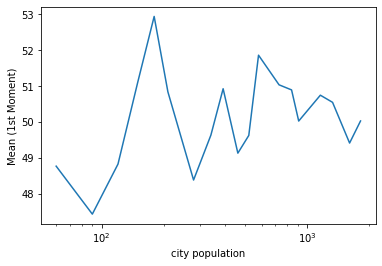

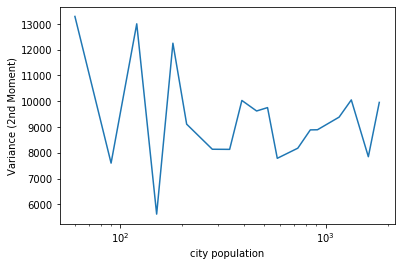

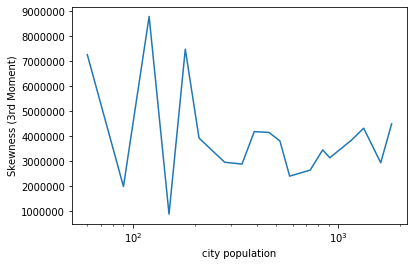

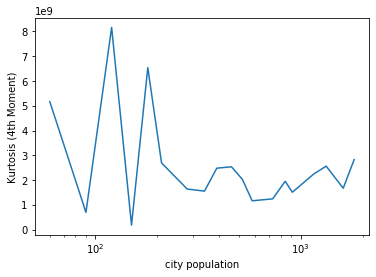

In [82]:
### IGNORE ###






# import scipy.stats
# import seaborn as sns



# # hists = meta_sim.hists
# # popsizes = meta_sim.popsizes
# # fig = plt.figure()
# kde_pdfs = {}
# def animate(i):
#     #label = label + ': G=' + str(round(gini(population), 2))
#     plt.cla()
#     lbl = "population = "+str(popsizes[i])
    
#     x = np.linspace(0.,max(hists[i]),100)
#     kernel = scipy.stats.gaussian_kde(hists[i])#,bw_method=wide_silverman)
#     kde_pdfs[popsizes[i]] = kernel.pdf
        
#     datx,daty = x,kernel.pdf(x)
    
#     plt.plot(datx,daty,c='red')
#     #ax2 = sns.rugplot(hists[i])
    
# #     metro = str(msa) in metro_ids
# #     msaname = idmappings["CBSA Title"][str(msa)]
# #     if not isinstance(msaname,str):
# #         msaname = list(msaname)[0]
# #     if metro:
# #         msaname += " (Metro Area)"
# #     else:
# #         msaname += " (Micro Area)"
        
#     plt.title(lbl)
#     plt.xlabel("income")
#     plt.ylabel("probability")
    
    
    
    
# #     plt.hist(hists[i], alpha = 0.4, range=(0,230),bins = 300, label=lbl)
# #     plt.legend()
# #     plt.xlabel('Wealth')
# #     plt.ylabel('Count')
#     plt.grid(True)

# anim = FuncAnimation(fig, animate, #init_func=init,
#                                #frames=76)#), interval=20)#, blit=True)
#                                frames=len(hists))#), interval=20)#, blit=True)
# HTML(anim.to_jshtml())


# class custom_distribution(scipy.stats.rv_continuous):
#     def _pdf(self, x, msa):
#         #print("in pdf,x = ",x,"msa=",msa)
#         #print("in pdf",x)
#         ret = kde_pdfs[msa[0]](x[0])
#         #print(ret)
#         #print("ret=",ret)
#         return ret

# distribution = custom_distribution(momtype=0)

# popsizes = popsizes[:-4]
# print(popsizes)
# print(kde_pdfs)
# set_trace()
# maps moment number n to list of those moments
# moments = {}
# cpops = []


# for psize in popsizes: 
#     for i in range(100):
#         print(i)
#         sample = distribution.rvs(msa)
#         samples.append(sample)
        
#     break

    #print("sample:",sample)
#     for n in range(1,5):
#         if n not in moments:
#             moments[n] = []
#         moments[n].append(distribution.moment(n,psize))
#         print("moment: n, val,pop:",n,moments[n],psize)
#     cpops.append(psize)
    
    

# scale_y = {
# #     1:1.,
# #     2:.5,
# #     3:.3,
# #     4:.3,
# #     5:.15

#     1:1.,
#     2:1.,
#     3:1.,
#     4:1.,
#     5:1.
# }

# #TODO: What's going on with the moments that evaluate to zero???

# for n in range(1,5):
#     plt.figure()
#     plt.xlabel("city population")
#     lbl = "nth moment, n = " + str(n) 
#     if n == 2:
#         lbl = "Variance (2nd Moment)"
#     elif n == 1:
#         lbl = "Mean (1st Moment)"
#     elif n == 3:
#         lbl = "Skewness (3rd Moment)"
#     elif n == 4:
#         lbl = "Kurtosis (4th Moment)"
#     plt.ylabel(lbl)
#     # TODO: fit regressions in log-linear space, calculate R^2 & p-value
#     plt.plot(cpops,moments[n],markersize=2)
#     bottom,top = plt.ylim()
#     plt.ylim((bottom,scale_y[n]*top))
#     #plt.yscale("log")
#     plt.xscale("log")
#     plt.show()
#     plt.close()
# #plt.hist(samples)

        
#     other_std = np.std(income_lists[msa])
#     #print(std,other_std)
#     stds.append(std)
#     raw_stds.append(other_std)
#     #means.append(distribution.moment(1,msa))


19
0
population = 60


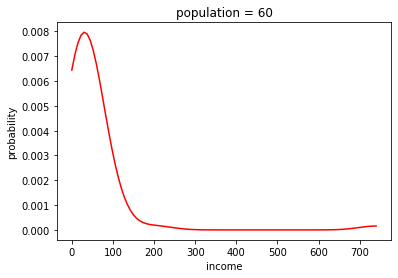

1
population = 90


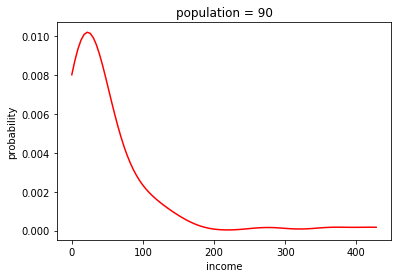

2
population = 120


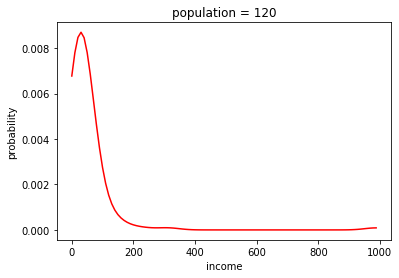

3
population = 150


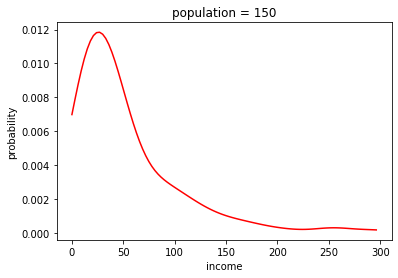

4
population = 180


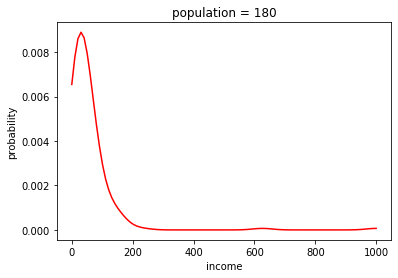

5
population = 210


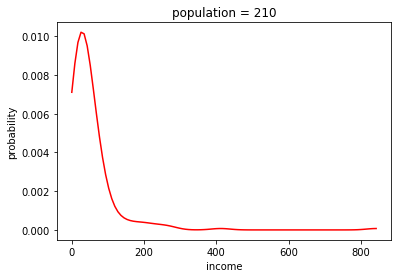

6
population = 280


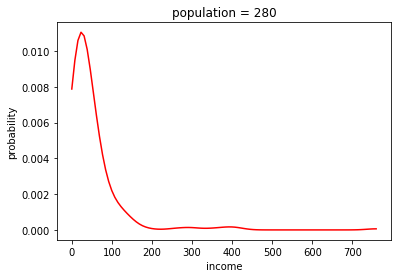

7
population = 340


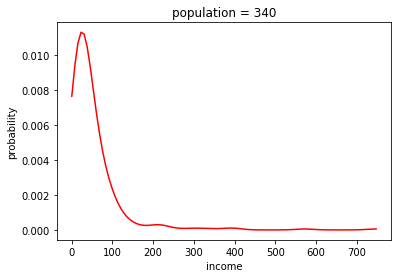

8
population = 390


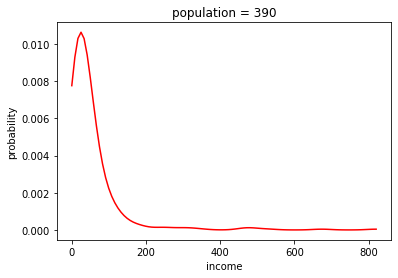

9
population = 460


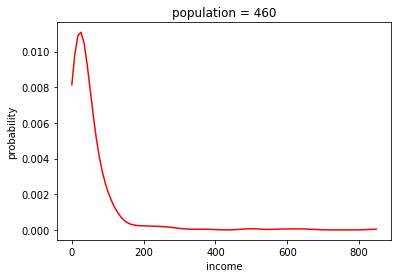

10
population = 520


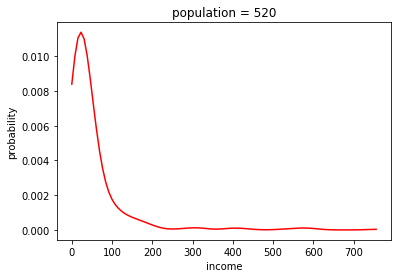

11
population = 580


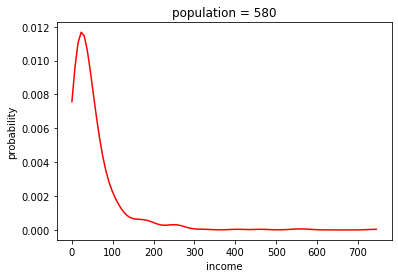

12
population = 730


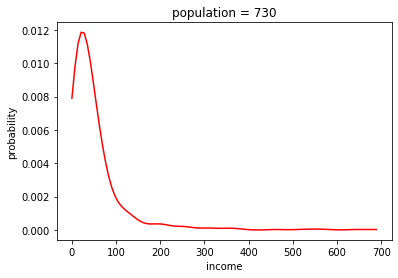

13
population = 840


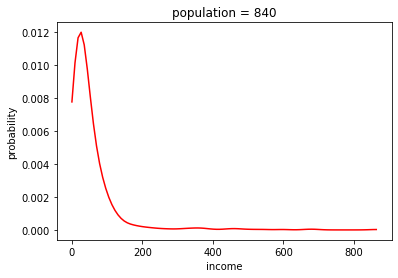

14
population = 910


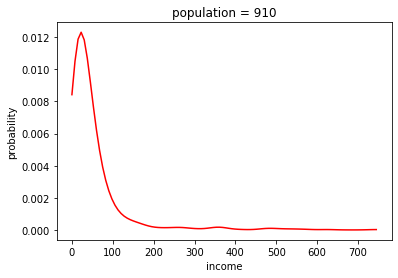

15
population = 1160


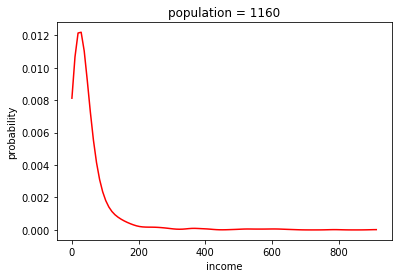

16
population = 1330


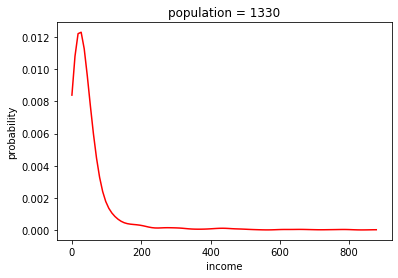

17
population = 1610


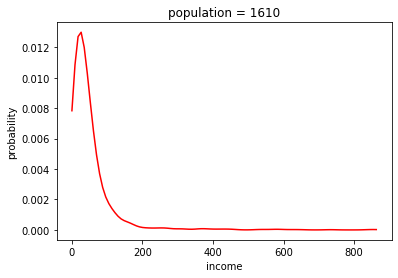

18
population = 1820


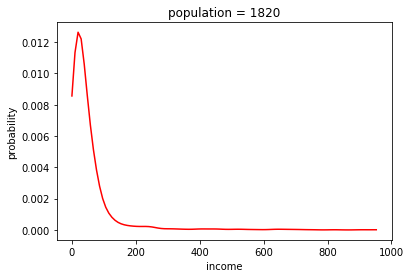

In [92]:
### IGNORE ###




# import scipy.stats
# import seaborn as sns



# # hists = meta_sim.hists
# # popsizes = meta_sim.popsizes
# # fig = plt.figure()
# print(len(hists))
# def animate(i):
#     #label = label + ': G=' + str(round(gini(population), 2))
#     plt.cla()
#     print(i)
#     lbl = "population = "+str(popsizes[i])
#     print(lbl)
    
#     x = np.linspace(0.,max(hists[i]),100)
#     kernel = scipy.stats.gaussian_kde(hists[i])#,bw_method=wide_silverman)
    
        
#     datx,daty = x,kernel.pdf(x)
    
#     plt.plot(datx,daty,c='red')
#     #ax2 = sns.rugplot(hists[i])
    
# #     metro = str(msa) in metro_ids
# #     msaname = idmappings["CBSA Title"][str(msa)]
# #     if not isinstance(msaname,str):
# #         msaname = list(msaname)[0]
# #     if metro:
# #         msaname += " (Metro Area)"
# #     else:
# #         msaname += " (Micro Area)"
        
#     plt.title(lbl)
#     plt.xlabel("income")
#     plt.ylabel("probability")
#     plt.close()
    
    
    
    
# #     plt.hist(hists[i], alpha = 0.4, range=(0,230),bins = 300, label=lbl)
# #     plt.legend()
# #     plt.xlabel('Wealth')
# #     plt.ylabel('Count')
#     plt.grid(True)

# # anim = FuncAnimation(fig, animate, #init_func=init,
# #                                #frames=76)#), interval=20)#, blit=True)
# #                                frames=len(hists))#), interval=20)#, blit=True)
# for i in range(len(hists)):
#     plt.gca()
#     print(i)
#     lbl = "population = "+str(popsizes[i])
#     print(lbl)
    
#     x = np.linspace(0.,max(hists[i]),100)
#     kernel = scipy.stats.gaussian_kde(hists[i])#,bw_method=wide_silverman)
    
        
#     datx,daty = x,kernel.pdf(x)
    
#     plt.plot(datx,daty,c='red')
#     #ax2 = sns.rugplot(hists[i])
    
# #     metro = str(msa) in metro_ids
# #     msaname = idmappings["CBSA Title"][str(msa)]
# #     if not isinstance(msaname,str):
# #         msaname = list(msaname)[0]
# #     if metro:
# #         msaname += " (Metro Area)"
# #     else:
# #         msaname += " (Micro Area)"
        
#     plt.title(lbl)
#     plt.xlabel("income")
#     plt.ylabel("probability")
#     plt.show()
#     plt.close()
    
# # HTML(anim.to_jshtml())



# """
# - convergence metric for KEMs
# - mean over distributions
# - mean over moments

# - income vs. wealth: show flux in/out


# """
